## Μέρος 3: Συνένωση Εικόνων (Image Stitching) για Δημιουργία Πανοράματος 

In [1]:
from scipy.stats import multivariate_normal
import cv2
from scipy import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.ndimage import label,map_coordinates,convolve1d, rank_filter
from numpy import unravel_index
import math
import glob
import base64
from numpy.linalg import norm
import os
import sys
%matplotlib inline


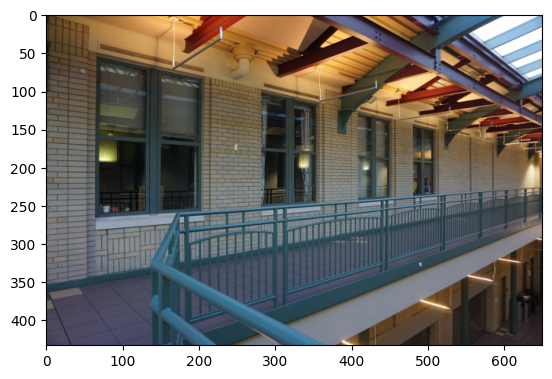

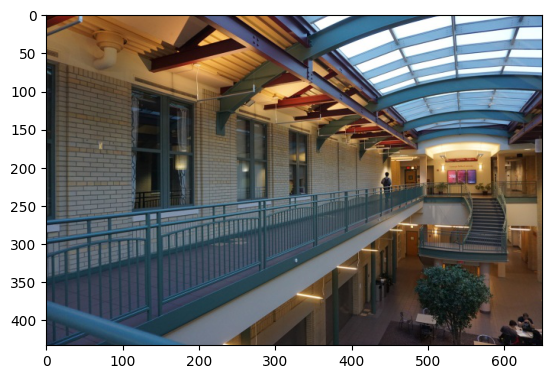

In [2]:
#Step 0 Read images 
img1a = cv2.imread('./cv24_lab2_part3/img1a_ratio05.jpg')
img1a = cv2.cvtColor(img1a,cv2.COLOR_BGR2RGB)
plt.imshow(img1a)
plt.show()
img1b = cv2.imread('./cv24_lab2_part3/img1b_ratio05.jpg')
img1b = cv2.cvtColor(img1b,cv2.COLOR_BGR2RGB)
plt.imshow(img1b)
plt.show()

gray1 = cv2.cvtColor(img1a, cv2.COLOR_BGR2GRAY)
gray2 = cv2.cvtColor(img1b, cv2.COLOR_BGR2GRAY)

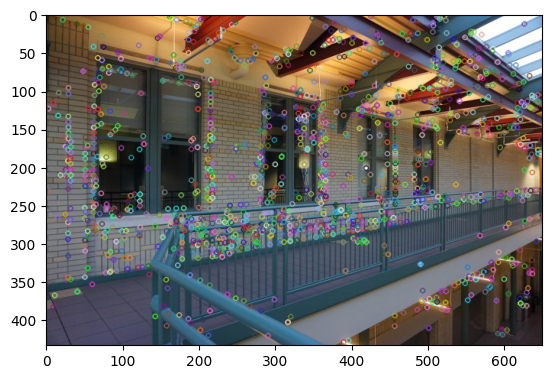

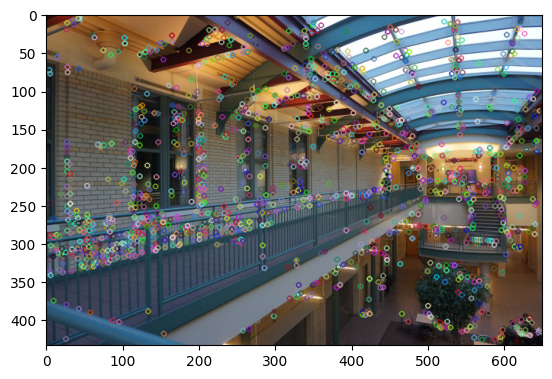

In [4]:
#Step 1: Extract SIFT feats using SIFT descriptor
sift = cv2.xfeatures2d.SIFT_create()

#Descriptor for the first image 
feats1, desc1 = sift.detectAndCompute(img1a,None)
sift_img1 = cv2.drawKeypoints(img1a,feats1,0)
#Plot the features of the first picture
plt.imshow(sift_img1)
plt.show()

#Descriptor for the second image
feats2, desc2 = sift.detectAndCompute(img1b,None)
sift_img2 = cv2.drawKeypoints(img1b,feats2,0)
#Plot the features of the second picture
plt.imshow(sift_img2)
plt.show()

In [103]:
#Step 2: Matching the features of two images using FLANN
#https://www.geeksforgeeks.org/python-opencv-flannbasedmatcher-function/
def FLANN_matching(img1,img2):
    sift = cv2.xfeatures2d.SIFT_create()
    #Keypoints and descriptors of the two images
    kp1, desc1 = sift.detectAndCompute(img1,None)
    kp2, desc2 = sift.detectAndCompute(img2,None)
    
    #FLANN parameters
    FLANN_INDEX_KDTREE = 0
    #First dictionary
    index_params = dict(algorithm = FLANN_INDEX_KDTREE,trees=5)
    #Second dictionary
    search_params = {}
    
    # FLANN based matcher with implementation of k nearest neighbour.
    flann = cv2.FlannBasedMatcher(index_params,search_params)
    matches = flann.knnMatch(desc1,desc2,k=2)
    
    #Step 3: Apply Lowe's ratio and keep the relevant matches
    #Filter matches using Lowe's ratio test
    ratio = 0.75
    good_matches = []
    for m,n in matches:
        if m.distance < ratio*n.distance:
            good_matches.append(m)
            
    print("Features before Lowe Threshold: ", np.shape(matches)[0])
    print("Features after Lowe Threshold: ", np.shape(good_matches)[0])       
    
    #Draw results, good matches
    img_matches = np.empty((max(img1.shape[0],img2.shape[0]),img1.shape[1]+img2.shape[1],3),dtype=np.uint8)
    img_lowe=cv2.drawMatches(img1,kp1,img2,kp2,good_matches,None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    #plt.figure(figsize=(20,8))
    #plt.imshow(img_lowe)
    #plt.show()
    
    #Calculating xA,xB vectors -> necessary for calculating homography
    img1_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    img2_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    return img1_pts, img2_pts
    
    
    

In [104]:
xA,xB = FLANN_matching(img1a,img1b)


Features before Lowe Threshold:  1743
Features after Lowe Threshold:  539


In [105]:
#Step 4: Using RANSAC calculate homography between the pictures
H, mask = cv2.findHomography(xA,xB,cv2.RANSAC,5.0)
print(H)

[[ 1.64564307e+00  2.48498767e-03 -3.21468967e+02]
 [ 2.06517328e-01  1.39037577e+00 -7.84873943e+01]
 [ 1.00125163e-03 -2.08206424e-05  1.00000000e+00]]


In [106]:
#Step 5: Calculating warped image using Inverse warping
def projectionImage(H,img):
    h,w,d = img.shape
    #Source points
    src_pts = np.float32([[[0,0]],[[w-1,0]],[[w-1,h-1]],[[0,h-1]]])
    #Destination points of the perspectived image
    dst_pts = cv2.perspectiveTransform(src_pts,H)
    
    #Top left coordinates
    A = dst_pts[0][0]  
    B = dst_pts[1][0]
    C = dst_pts[2][0]
    D = dst_pts[3][0]
    
    #Calculate height and width of the resulted image
    AD = np.sqrt((A[0]-D[0])**2 + (A[1]-D[1])**2)
    BC = np.sqrt((B[0]-C[0])**2 + (B[1]-C[1])**2)
    heigth = int(max(AD,BC))
    
    AB = np.sqrt((A[0]-B[0])**2 + (A[1]-B[1])**2)
    DC = np.sqrt((D[0]-C[0])**2 + (D[1]-C[1])**2)
    width = int(max(AB,DC))
    
    #Find image transformer: top_left -> 0,0 + homographic transformation
    move = np.float32([[1,0,-A[0]],
                       [0,1,-A[1]],
                       [0,0,1]])
    M = np.matmul(move,H)
    
    img1_warped = cv2.warpPerspective(img,M,(width,heigth))
    
    return img1_warped, A

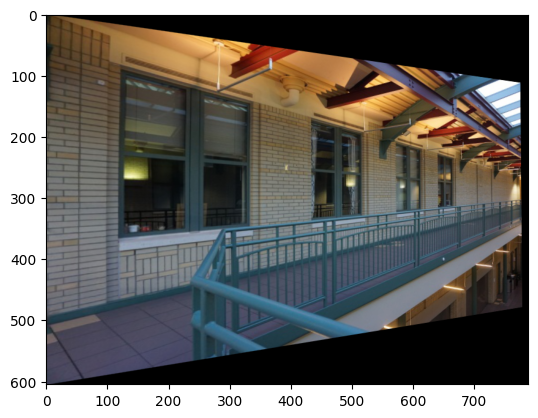

In [107]:
#Testing
img1_warped,img1_topleft_coords=projectionImage(H,img1a)
plt.imshow(img1_warped)

In [108]:
#Step6: Stitch images
def mergeWarpedImages(img1_warped, img2, img1_topleft_coords):
    h,w,d = img2.shape
    #Move img2 according to topleft coords
    width = w-int(img1_topleft_coords[0])
    heigth = h-int(img1_topleft_coords[1])
    
    M = np.float32([[1,0,-img1_topleft_coords[0]],
                    [0,1,-img1_topleft_coords[1]],
                    [0,0,1]])
    img2_warped = cv2.warpPerspective(img2,M,(width,heigth))
    
    #Find the size of the result
    heigth = max(img1_warped.shape[0],img2_warped.shape[0])
    width = max(img1_warped.shape[1],img2_warped.shape[1])
    
    #Bring both images to same size
    img1_final = cv2.warpPerspective(img1_warped,np.identity(3),(width,heigth))
    img2_final = cv2.warpPerspective(img2_warped,np.identity(3),(width,heigth))
    #Delete those pixels that overlap
    condition = (img2_final > 0)
    img1_final = np.where(condition,0,img1_final)
    
    return img1_final + img2_final
    

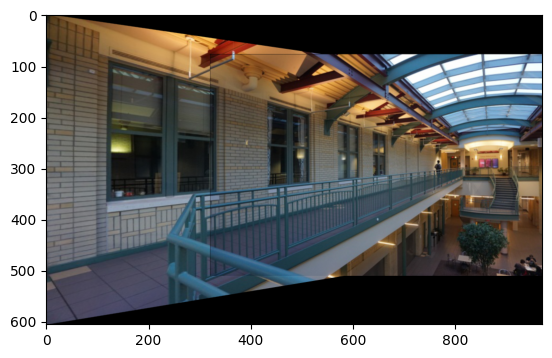

In [109]:
img1 = mergeWarpedImages(img1_warped, img1b, img1_topleft_coords)
plt.imshow(img1)

In [110]:
#Making a function that stiches two images based on the above steps
def stichImages(img1,img2):
    #Step1-2-3: extract SIFT keypoints and descriptors, match points and apply Lowe's ratio
    img1_pts,img2_pts = FLANN_matching(img1,img2)
    #Step4: using RANSAC calculate homography between the 2 pictures
    H, mask = cv2.findHomography(img1_pts,img2_pts,cv2.RANSAC,5.0)
    #Step5: Project img1 to the space of img2
    img1_warped, img1_topleft_coords = projectionImage(H,img1)
    #Step6: merge the 2 images to a final
    mrg_image = mergeWarpedImages(img1_warped, img2, img1_topleft_coords)
    
    return mrg_image
    

(433, 650, 3)
(433, 650, 3)
(433, 650, 3)
(433, 650, 3)
(433, 650, 3)
(433, 650, 3)


Text(0.5, 1.0, 'Image 6')

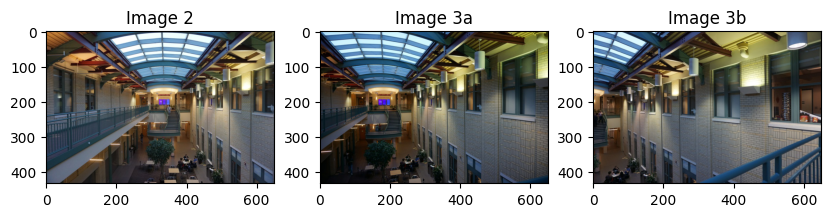

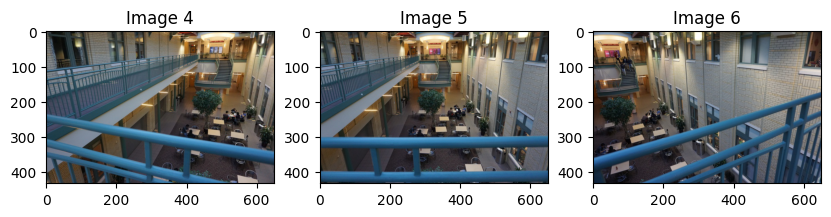

In [111]:
#Making panorama 
#Read the remaining images
img2 = cv2.imread('./cv24_lab2_part3/img2_ratio05.jpg')
img2 = cv2.cvtColor(img2,cv2.COLOR_BGR2RGB)
print(img2.shape)

img3a = cv2.imread('./cv24_lab2_part3/img3a_ratio05.jpg')
img3a = cv2.cvtColor(img3a,cv2.COLOR_BGR2RGB)
print(img3a.shape)

img3b = cv2.imread('./cv24_lab2_part3/img3b_ratio05.jpg')
img3b = cv2.cvtColor(img3b,cv2.COLOR_BGR2RGB)
print(img3b.shape)

img4 = cv2.imread('./cv24_lab2_part3/img4_ratio05.jpg')
img4 = cv2.cvtColor(img4,cv2.COLOR_BGR2RGB)
print(img4.shape)

img5 = cv2.imread('./cv24_lab2_part3/img5_ratio05.jpg')
img5 = cv2.cvtColor(img5,cv2.COLOR_BGR2RGB)
print(img5.shape)

img6 = cv2.imread('./cv24_lab2_part3/img6_ratio05.jpg')
img6 = cv2.cvtColor(img6,cv2.COLOR_BGR2RGB)
print(img6.shape)

fig1, ax1 = plt.subplots(1, 3, figsize = (10,30))
ax1[0].imshow(img2)
ax1[1].imshow(img3a)
ax1[2].imshow(img3b)
ax1[0].set_title("Image 2")
ax1[1].set_title("Image 3a")
ax1[2].set_title("Image 3b")

fig2, ax2 = plt.subplots(1, 3, figsize = (10,30))
ax2[0].imshow(img4)
ax2[1].imshow(img5)
ax2[2].imshow(img6)
ax2[0].set_title("Image 4")
ax2[1].set_title("Image 5")
ax2[2].set_title("Image 6")


Features before Lowe Threshold:  1306
Features after Lowe Threshold:  556
Features before Lowe Threshold:  2273
Features after Lowe Threshold:  324
(1977, 3306, 3)


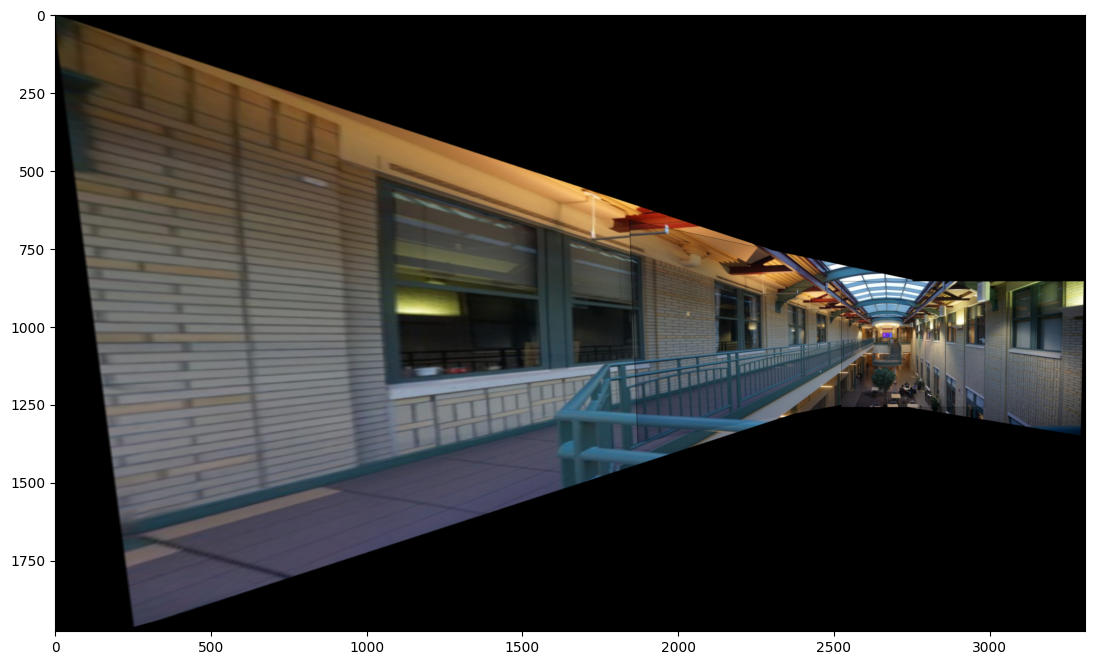

In [133]:
img23a = stichImages(img3a,img2) #img3a: warped, img2:σταθερη
img123 = stichImages(img1,img23a) #img1: warped, img23a:σταθερη
print(img123.shape)
plt.figure(figsize=(30,8))
plt.imshow(img123)

Features before Lowe Threshold:  1599
Features after Lowe Threshold:  535
Features before Lowe Threshold:  1447
Features after Lowe Threshold:  377
Features before Lowe Threshold:  2238
Features after Lowe Threshold:  610
(824, 1659, 3)


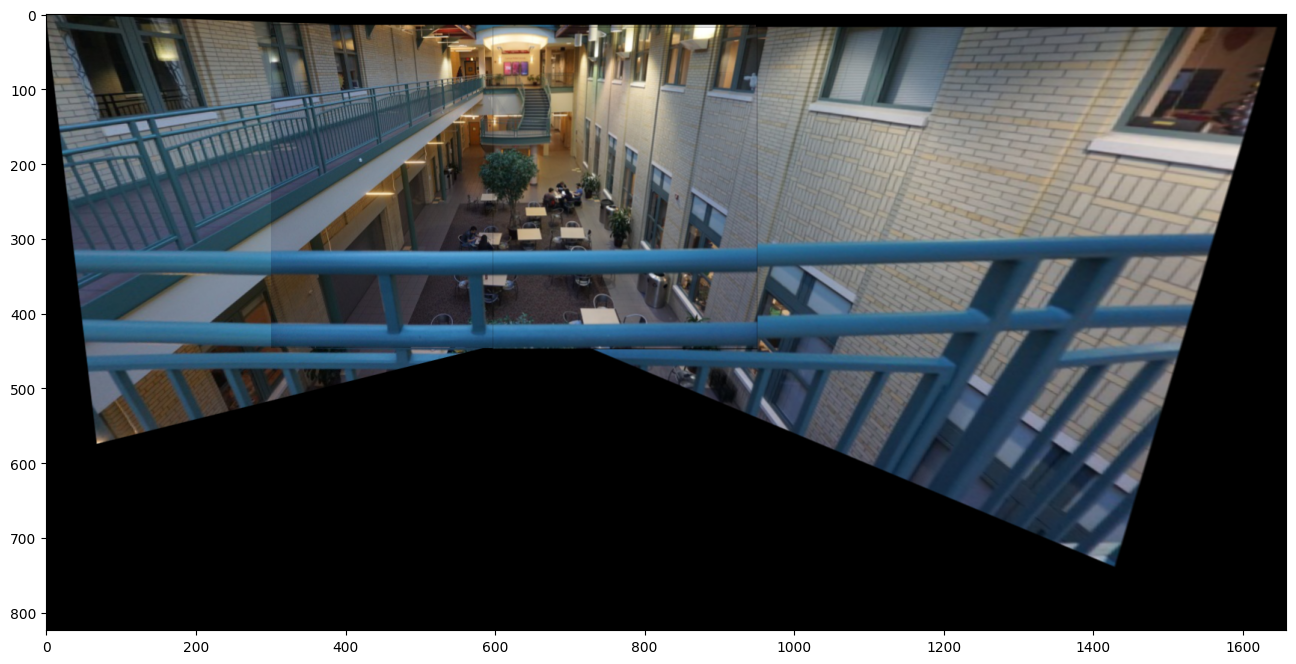

In [140]:
img45 = stichImages(img4, img5) #img4:warped, img5:σταθερη
img56= stichImages(img6,img5)   #img6:warped, img5:σταθερη
img456= stichImages(img45,img56)
plt.figure(figsize=(30,8))
plt.imshow(img456)
print(img456.shape)

Features before Lowe Threshold:  2723
Features after Lowe Threshold:  548
(12841, 15518, 3)


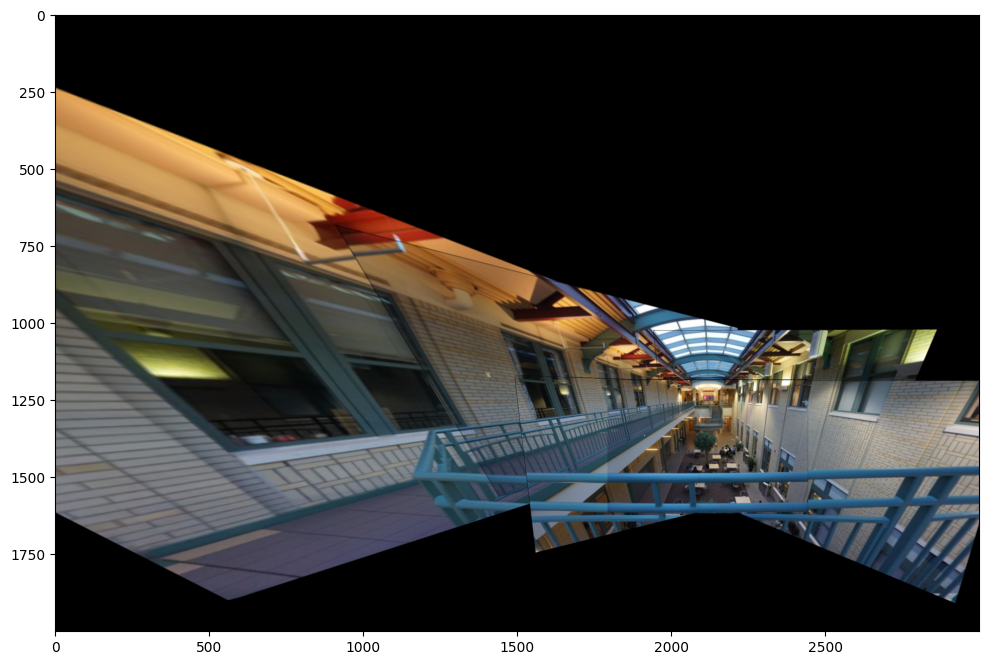

In [139]:
img_all = stichImages(img123,img456)
plt.figure(figsize=(30,8))
plt.imshow(img_all[4000:6000,11000:14000,:])
print(img_all.shape)